# 공유 자전거 대여수의 인과관계 파악하기 
https://programmers.co.kr/learn/courses/21/lessons/942

* datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals


In [1]:
from dowhy import CausalModel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

plt.rcParams["font.family"] = "nanumgothic"
bike = pd.read_csv("train.csv")
print(bike.shape)
bike.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## 전처리
1. 날짜 전처리
2. 게절 & 날씨 전처리
3. 원핫 인코딩
4.변수 삭제

In [2]:
def month_to_season(x):
    if x in [3,4,5]:
        y = "spring"
    elif x in [6,7,8]:
        y = "summer"
    elif x in [9,10,11]:
        y = "autumn"
    else:
        y = "winter"
    return (y)

def weather(x):
    if   x==1:
        y = "clear"
    elif x==2:
        y = "cloudy"
    elif x==3:
        y = "light_rainy"
    else:
        y = "heavy_rainy"
    return (y)

In [3]:
# 1. 날짜 전처리
bike['datetime'] = pd.to_datetime(bike['datetime'])
bike['year']  = bike['datetime'].apply(lambda x: x.year)
bike['month'] = bike['datetime'].apply(lambda x: x.month)
bike['day']   = bike['datetime'].apply(lambda x: x.day)
bike['hour']  = bike['datetime'].apply(lambda x: x.hour)         # 시간대
bike['dayofweek'] = bike['datetime'].apply(lambda x:x.weekday()) # 요일

# 2. 계절 전처리
bike['season'] = bike["month"].apply(lambda x: month_to_season(x))

# 3. 날짜 전처리
bike['weather'] = bike["weather"].apply(lambda x: weather(x))

# 4. 원핫 인코딩 생성
season_dummies = pd.get_dummies(bike['season'])
weather_dummies= pd.get_dummies(bike['weather'])
bike = pd.concat([bike,season_dummies,weather_dummies],axis=1)

# 5. 변수 삭제
bike = bike.drop(["casual","registered"],axis=1)

In [4]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,...,hour,dayofweek,autumn,spring,summer,winter,clear,cloudy,heavy_rainy,light_rainy
0,2011-01-01 00:00:00,winter,0,0,clear,9.84,14.395,81,0.0,16,...,0,5,0,0,0,1,1,0,0,0
1,2011-01-01 01:00:00,winter,0,0,clear,9.02,13.635,80,0.0,40,...,1,5,0,0,0,1,1,0,0,0
2,2011-01-01 02:00:00,winter,0,0,clear,9.02,13.635,80,0.0,32,...,2,5,0,0,0,1,1,0,0,0
3,2011-01-01 03:00:00,winter,0,0,clear,9.84,14.395,75,0.0,13,...,3,5,0,0,0,1,1,0,0,0
4,2011-01-01 04:00:00,winter,0,0,clear,9.84,14.395,75,0.0,1,...,4,5,0,0,0,1,1,0,0,0


## EDA

[Text(0.5, 1.0, '시간 별 대여량')]

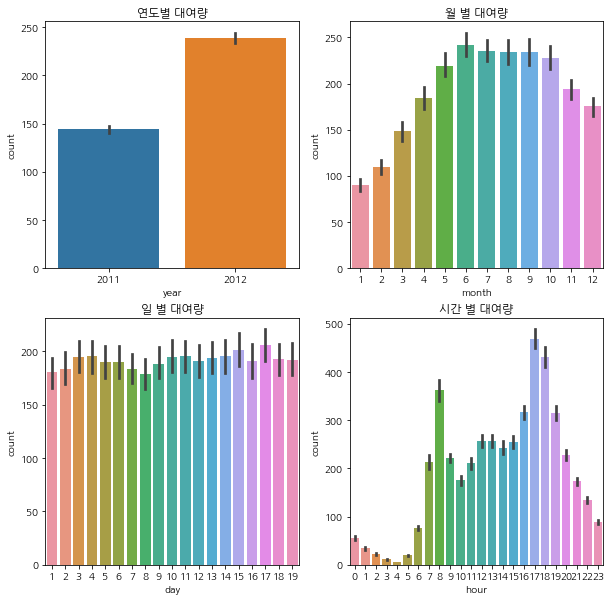

In [5]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_size_inches(10,10)
sns.barplot(x="year",y="count", data = bike,ax=ax1)
sns.barplot(x="month",y="count", data = bike,ax=ax2)
sns.barplot(x="day",y="count", data = bike,ax=ax3)
sns.barplot(x="hour",y="count", data = bike,ax=ax4)
ax1.set(title = "연도별 대여량")
ax2.set(title = "월 별 대여량")
ax3.set(title = "일 별 대여량")
ax4.set(title = "시간 별 대여량")

[Text(0.5, 1.0, '휴일 여부에 따른 대여량')]

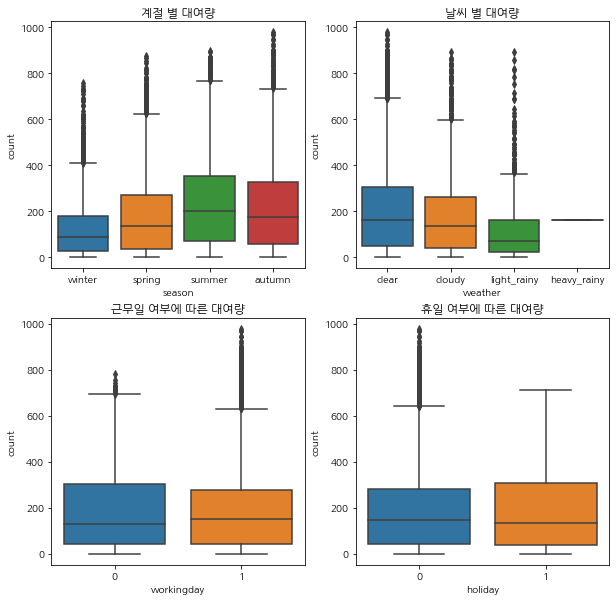

In [6]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_size_inches(10,10)

sns.boxplot(data=bike,y="count",x="season",orient="v", ax=ax1)
sns.boxplot(data=bike,y="count",x="weather",orient="v", ax=ax2)
sns.boxplot(data=bike,y="count",x="workingday",orient="v", ax=ax3)
sns.boxplot(data=bike,y="count",x="holiday",orient="v", ax=ax4)
ax1.set(title="계절 별 대여량")
ax2.set(title="날씨 별 대여량")
ax3.set(title="근무일 여부에 따른 대여량")
ax4.set(title="휴일 여부에 따른 대여량")

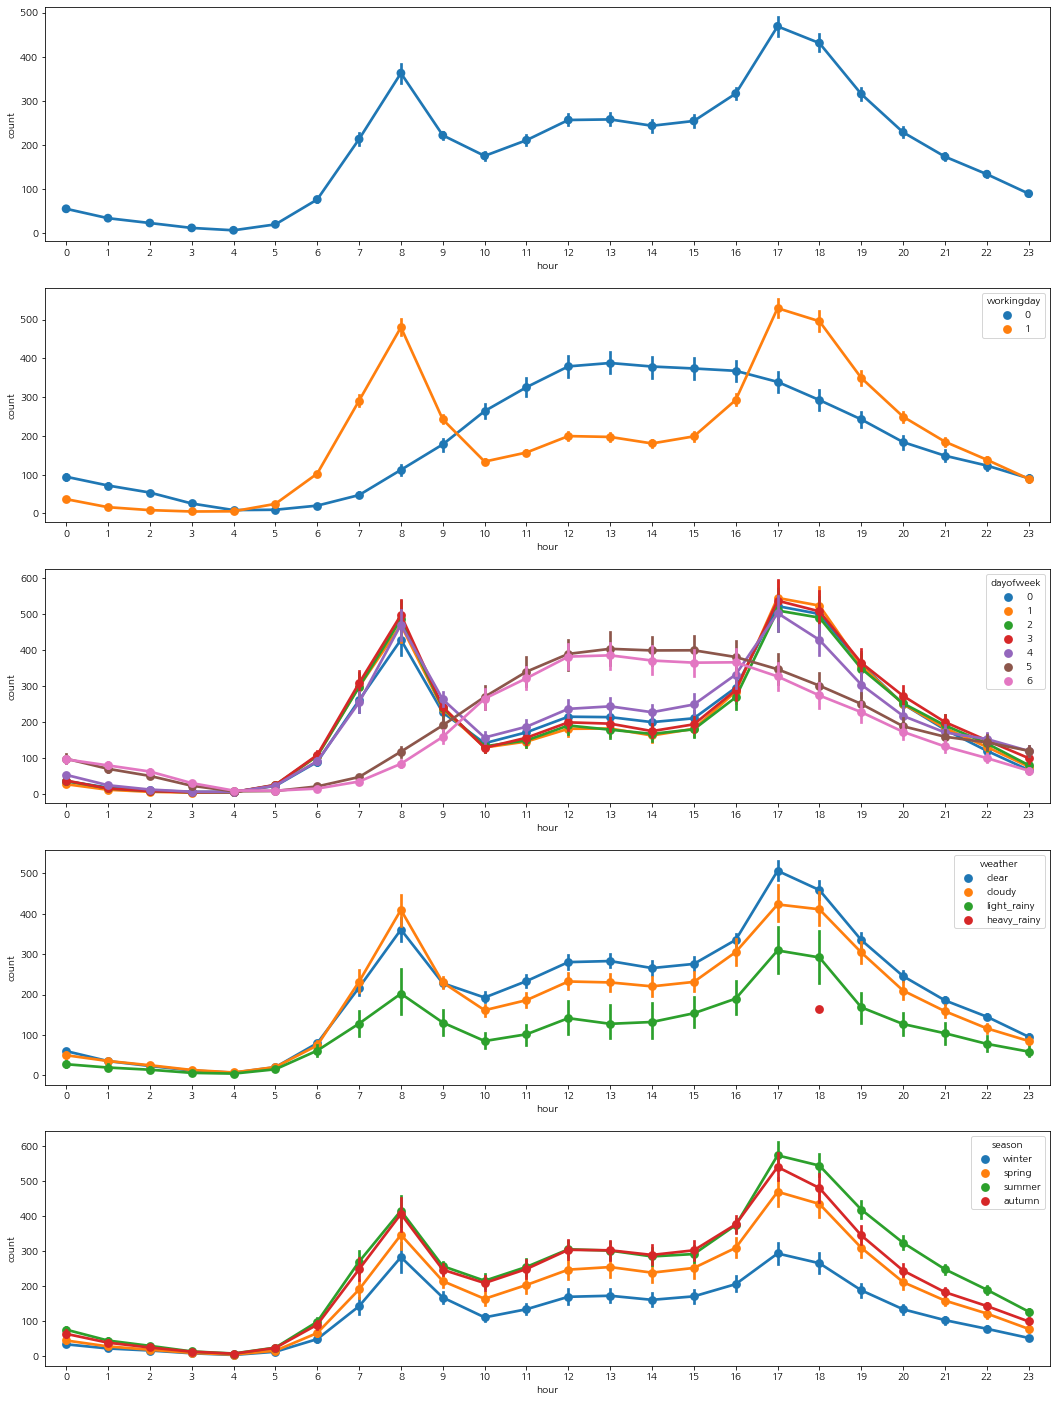

In [7]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=bike,x="hour",y="count",ax=ax1)
sns.pointplot(data=bike,x="hour",y="count",hue="workingday",ax=ax2)
sns.pointplot(data=bike,x="hour",y="count",hue="dayofweek",ax=ax3)
sns.pointplot(data=bike,x="hour",y="count",hue="weather",ax=ax4)
sns.pointplot(data=bike,x="hour",y="count",hue="season",ax=ax5)

* 연도, 계절, 시간, 주말 여부, 날씨에 큰 영향을 받음
* 근무일 여부, 휴일 여부는 오히려 영향을 덜 주는 편 

## 2차 전처리

In [8]:
bike["is_winter"]=bike["winter"].apply(lambda x: True if x == 1 else False)
bike["is_rainy"]=bike["weather"].apply(lambda x: True if x == "heavy_rainy" or x== "light_rainy" else False)
bike["is_rush_hour"]=bike["hour"].apply(lambda x: True if (x>=7 and x<=9) or (x>=16 and x<=19) else False)
bike["is_2012"] = bike["year"].apply(lambda x: True if x==2012 else False)

## Causal Model

In [35]:
list(bike)

['datetime',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'count',
 'year',
 'month',
 'day',
 'hour',
 'dayofweek',
 'autumn',
 'spring',
 'summer',
 'winter',
 'clear',
 'cloudy',
 'heavy_rainy',
 'light_rainy',
 'is_winter',
 'is_rainy',
 'is_rush_hour',
 'is_2012',
 'propensity_score',
 'strata',
 'dbar',
 'd_y',
 'dbar_y']

In [50]:
winter_effect = CausalModel(
    data=bike,
    treatment = "is_winter",
    outcome = "count",
    common_causes = "temp+atemp+humidity+windspeed+holiday+hour+clear+cloudy+heavy_rainy+light_rainy".split("+"))

winter_identified = winter_effect.identify_effect()

winter_matching = winter_effect.estimate_effect(winter_identified,method_name = "backdoor.propensity_score_matching")
winter_stratify = winter_effect.estimate_effect(winter_identified,method_name = "backdoor.propensity_score_stratification")

print("Causal Estimate of Matching: {}".format(winter_matching.value))
print("Causal Estimate of Stratification: {}".format(winter_stratify.value))

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['is_winter'] on outcome ['count']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['light_rainy', 'holiday', 'U', 'atemp', 'cloudy', 'heavy_rainy', 'hour', 'windspeed', 'humidity', 'clear', 'temp']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: count~is_winter+light_rainy+holiday+atemp+cloudy+heavy_rainy+hour+windspeed+humidity+clear+temp
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

Causal Estimate of Matching: -0.4830975564945802
Causal Estimate of Stratification: -1.7564619691542278


In [55]:
rainy_effect = CausalModel(
    data=bike,
    treatment = "is_rainy",
    outcome   = "count",
    common_causes = "temp+atemp+humidity+windspeed+spring+summer+autumn+is_2012".split("+"),
    effect_modifiers = "is_rush_hour+holiday".split("+"))

rainy_identified = rainy_effect.identify_effect()

rainy_matching = rainy_effect.estimate_effect(rainy_identified,method_name = "backdoor.propensity_score_matching")
rainy_stratify = rainy_effect.estimate_effect(rainy_identified,method_name = "backdoor.propensity_score_stratification")

print("Causal Estimate of Matching: {}".format(rainy_matching.value))
print("Causal Estimate of Stratification: {}".format(rainy_stratify.value))

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['is_rainy'] on outcome ['count']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'atemp', 'is_2012', 'autumn', 'summer', 'windspeed', 'spring', 'humidity', 'temp']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: count~is_rainy+atemp+is_2012+autumn+summer+windspeed+spring+humidity+temp
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

Causal Estimate of Matching: -5.973268418151754
Causal Estimate of Stratification: -10.434986509124656


In [56]:
# 1. 무관한 교란변수 생성
rainy_random    = rainy_effect.refute_estimate(rainy_identified, rainy_matching,method_name="random_common_cause")
# 2. 가짜 처리 생성
rainy_placebo   = rainy_effect.refute_estimate(rainy_identified, rainy_matching,method_name="placebo_treatment_refuter", placebo_type="permute")
# 3. 일부만 추출
rainy_subset    = rainy_effect.refute_estimate(rainy_identified, rainy_matching,method_name="data_subset_refuter", subset_fraction=0.8)

rainy_random_str    = rainy_effect.refute_estimate(rainy_identified, rainy_stratify,method_name="random_common_cause")
rainy_placebo_str   = rainy_effect.refute_estimate(rainy_identified, rainy_stratify,method_name="placebo_treatment_refuter", placebo_type="permute")
rainy_subset_str    = rainy_effect.refute_estimate(rainy_identified, rainy_stratify,method_name="data_subset_refuter", subset_fraction=0.8)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: count~is_rainy+atemp+is_2012+autumn+summer+windspeed+spring+humidity+temp+w_random
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLV

In [57]:
print(rainy_random)
print(rainy_placebo)
print(rainy_subset)

print(rainy_random_str)
print(rainy_placebo_str)
print(rainy_subset_str)

Refute: Add a Random Common Cause
Estimated effect:(-5.973268418151754,)
New effect:(-10.403545838691898,)

Refute: Use a Placebo Treatment
Estimated effect:(-5.973268418151754,)
New effect:(-6.113356604813522,)

Refute: Use a subset of data
Estimated effect:(-5.973268418151754,)
New effect:(-9.094270295097026,)

Refute: Add a Random Common Cause
Estimated effect:(-10.434986509124656,)
New effect:(-21.301415881273474,)

Refute: Use a Placebo Treatment
Estimated effect:(-10.434986509124656,)
New effect:(4.483875208301899,)

Refute: Use a subset of data
Estimated effect:(-10.434986509124656,)
New effect:(-20.62884261683204,)

